## Scoring customer propensity to purchase
Training a model based on a shoppers actions on a website to identify the best prospects who did not purchase yesterday.

### Introduction
We have many visitors to our website every day, some purchase but many do not. We spend money re-targeting past visitors, we'd like to optomise this activity by targeting the visitors who are more likely to convert. To do this, we've taken data showing which parts of our website users interacted with, our questions are:

1. Which of these interactiuons effect a users likelyhood to purchase?
2. Can we score visitors from yesterday who did not purchase, to see who the most valauve prospects are?

![](https://image.ibb.co/ecGtqy/stats_2.png)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

First let's load in the training data file and take a look at it...

In [4]:
train = pd.read_csv('/Users/mohitdhillon/Documents/projects/propensity/training_sample.csv')

train.dtypes

UserID                     object
basket_icon_click           int64
basket_add_list             int64
basket_add_detail           int64
sort_by                     int64
image_picker                int64
account_page_click          int64
promo_banner_click          int64
detail_wishlist_add         int64
list_size_dropdown          int64
closed_minibasket_click     int64
checked_delivery_detail     int64
checked_returns_detail      int64
sign_in                     int64
saw_checkout                int64
saw_sizecharts              int64
saw_delivery                int64
saw_account_upgrade         int64
saw_homepage                int64
device_mobile               int64
device_computer             int64
device_tablet               int64
returning_user              int64
loc_uk                      int64
ordered                     int64
dtype: object

Okay, so we have a bunch of integer columns, each one reflecting an action on the website, and oneobject column, which looks like a user identifier, Let's take a look with some more methods...

In [5]:
print(train.describe())

print(train.info())

       basket_icon_click  basket_add_list  basket_add_detail        sort_by  \
count      455401.000000    455401.000000      455401.000000  455401.000000   
mean            0.099150         0.074521           0.112916       0.036849   
std             0.298864         0.262617           0.316490       0.188391   
min             0.000000         0.000000           0.000000       0.000000   
25%             0.000000         0.000000           0.000000       0.000000   
50%             0.000000         0.000000           0.000000       0.000000   
75%             0.000000         0.000000           0.000000       0.000000   
max             1.000000         1.000000           1.000000       1.000000   

        image_picker  account_page_click  promo_banner_click  \
count  455401.000000       455401.000000       455401.000000   
mean        0.026735            0.003570            0.016208   
std         0.161307            0.059647            0.126274   
min         0.000000            

So it looks like this data is just below half a million rows, with a total of 25 columns. Let's take a look at some of the data using HEAD...

In [6]:
train.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


Here we can see a clear snspshot of the data, we have 1's or 0's in the columns, indicating wheather or not a user interacted with these areas of the website. The last colum shows whether the user ordered or not, this will be important!


### Is there any correlation
In order to answer our first question, we can start by exploring any correlation between there individual website actions and an order, since we have all thes fields in our data.

We've got quite a few fields, so let's start with a heatmap to view correlations...

/var/folders/kk/3csz3h6n39j4h1xsf3h235wr0000gn/T/ipykernel_85314/2595861266.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


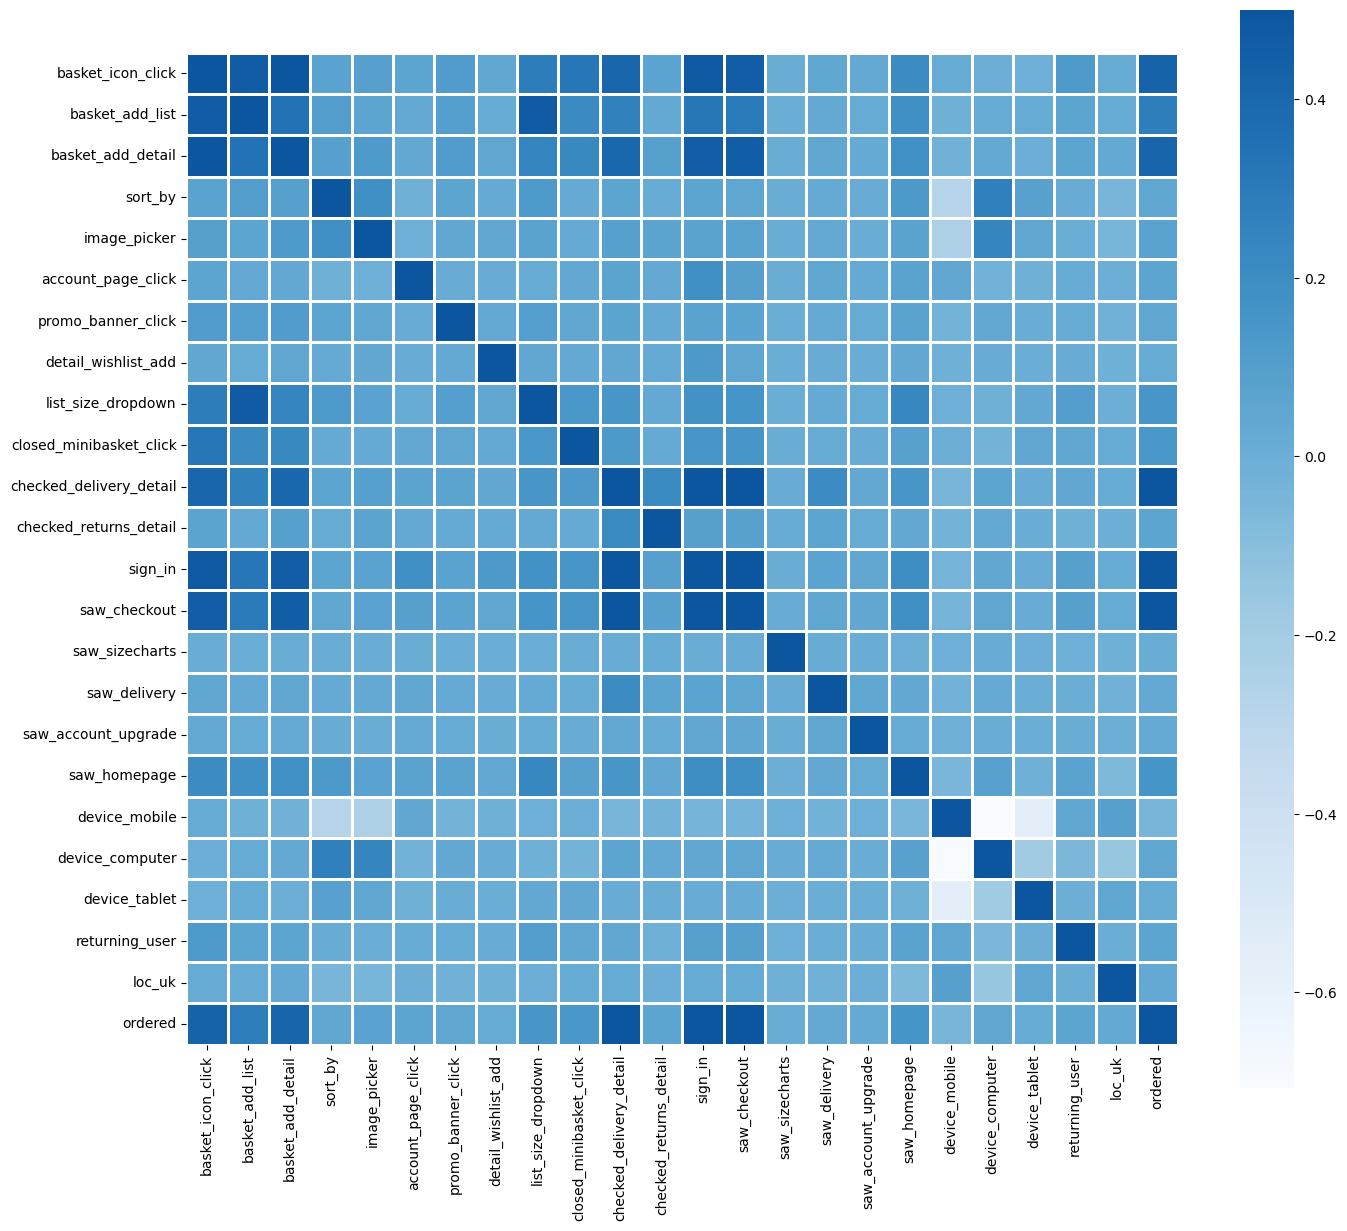

In [7]:
import seaborn as sns
corr = train.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues')
plt.savefig("heatmap.png")
plt.show()

Interesting - there seems to be a strong correlation between visitors who ordered and visitors who saw the checkout, this makes sense! There are also strong correlations for people who cheked out delivery times and added items to their shopping cart - let's get a closer look at the correlations for orders...

In [8]:
train.corr()['ordered']

/var/folders/kk/3csz3h6n39j4h1xsf3h235wr0000gn/T/ipykernel_85314/1995792893.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()['ordered']


basket_icon_click          0.428334
basket_add_list            0.287666
basket_add_detail          0.414420
sort_by                    0.054636
image_picker               0.071492
account_page_click         0.057279
promo_banner_click         0.056533
detail_wishlist_add        0.023516
list_size_dropdown         0.154867
closed_minibasket_click    0.140011
checked_delivery_detail    0.798720
checked_returns_detail     0.059484
sign_in                    0.665556
saw_checkout               0.708986
saw_sizecharts             0.007548
saw_delivery               0.031461
saw_account_upgrade        0.025857
saw_homepage               0.157778
device_mobile             -0.042907
device_computer            0.049208
device_tablet              0.016939
returning_user             0.060295
loc_uk                     0.031643
ordered                    1.000000
Name: ordered, dtype: float64

Alright! Looks like our initial insights from the heatmap were correct, users who checked out the delivery options on a product detail page have an almost 80% correlation to orders.

### Let's get predicting!
First we build our predictor and targets variables, we're going to drop 'ordered' form our predictors, as it is our target variable. We'll also remove 'UserID', as it has no impact on likelyhood to order.

In [21]:
# Drop columns with low correlation
predictors = train.drop(['ordered','UserID'], axis=1)
# predictors = train[['checked_delivery_pdp', 'basket_icon_click', 'sign_in', 'saw_checkout']]
targets = train.ordered

Let's take a look at our predictor columns to check we've included everything we wanted, and not left in something we shouldn't have...

In [22]:
print(predictors.columns)

Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by',
       'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk'],
      dtype='object')


Now we split our data into train and test, with a test size of 30%.

In [23]:
X_train, X_test, y_train, y_test  =   train_test_split(predictors, targets, test_size=.3)

print( "Predictor - Training : ", X_train.shape, "Predictor - Testing : ", X_test.shape )

Predictor - Training :  (318780, 23) Predictor - Testing :  (136621, 23)


For our model we are going to use a naise bayes classififer, below we instantiate it, fit it, then predict using it, then we an analyse the accuracy of our predictions...

In [24]:
from sklearn.naive_bayes import GaussianNB

classifier=GaussianNB()
classifier=classifier.fit(X_train,y_train)

predictions=classifier.predict(X_test)

#Analyze accuracy of predictions
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[129455,   1503],
       [    77,   5586]])

And apply an accuracy score to our model...

In [25]:
sklearn.metrics.accuracy_score(y_test, predictions)

0.9884351600412821

### Now to predict on the previous days visitors!
Start by loading in our sample data of the **previous days visitors who did not order**.

In [26]:
yesterday_prospects = pd.read_csv('/Users/mohitdhillon/Documents/projects/propensity/testing_sample.csv')


Now let's explore this DataFrame and check everything is as expected...

In [27]:
print(yesterday_prospects.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151655 entries, 0 to 151654
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   151655 non-null  object
 1   basket_icon_click        151655 non-null  int64 
 2   basket_add_list          151655 non-null  int64 
 3   basket_add_detail        151655 non-null  int64 
 4   sort_by                  151655 non-null  int64 
 5   image_picker             151655 non-null  int64 
 6   account_page_click       151655 non-null  int64 
 7   promo_banner_click       151655 non-null  int64 
 8   detail_wishlist_add      151655 non-null  int64 
 9   list_size_dropdown       151655 non-null  int64 
 10  closed_minibasket_click  151655 non-null  int64 
 11  checked_delivery_detail  151655 non-null  int64 
 12  checked_returns_detail   151655 non-null  int64 
 13  sign_in                  151655 non-null  int64 
 14  saw_checkout        

We're going to drop UserID before we predict on this data, so that is matches our training set, but before we do let's pop it into another variable, so we can pull back this identifier later. Once that's done we can drop our unwanted fields and print the head() to check our data...looking good?

In [28]:
userids = yesterday_prospects.UserID

yesterday_prospects = yesterday_prospects.drop(['ordered','UserID'], axis=1)

print(yesterday_prospects.head(10))

   basket_icon_click  basket_add_list  basket_add_detail  sort_by  \
0                  0                0                  0        0   
1                  0                0                  0        0   
2                  0                0                  0        0   
3                  0                0                  1        0   
4                  0                0                  0        0   
5                  1                0                  1        0   
6                  0                0                  0        0   
7                  0                0                  0        0   
8                  1                1                  1        0   
9                  0                0                  0        0   

   image_picker  account_page_click  promo_banner_click  detail_wishlist_add  \
0             0                   0                   0                    0   
1             0                   0                   0                    0   


Let's check the shape too, to confirm it is what our model will expect to recieve (e.g. the same number of columns)

In [29]:
yesterday_prospects.shape

(151655, 23)

Now we'll run our predictions and insert them into a field called 'propensity', print the head, and check it's all come togeather...

In [30]:
yesterday_prospects['propensity'] = classifier.predict_proba(yesterday_prospects)[:,1]

print(yesterday_prospects.head())

   basket_icon_click  basket_add_list  basket_add_detail  sort_by  \
0                  0                0                  0        0   
1                  0                0                  0        0   
2                  0                0                  0        0   
3                  0                0                  1        0   
4                  0                0                  0        0   

   image_picker  account_page_click  promo_banner_click  detail_wishlist_add  \
0             0                   0                   0                    0   
1             0                   0                   0                    0   
2             0                   0                   0                    0   
3             0                   0                   0                    0   
4             0                   0                   0                    0   

   list_size_dropdown  closed_minibasket_click  ...  saw_sizecharts  \
0                   0            

Looks good! Now we want to bring out UserIDs back, so we can identify these users in the future (note, these are dummy IDs).

In [31]:
pd.DataFrame(userids)
results = pd.concat([userids, yesterday_prospects], axis=1)

All done - let's take a look at our results data frame:

In [32]:
print(results.head(30))

                                 UserID  basket_icon_click  basket_add_list  \
0   9d24-25k4-47889d24-25k4-494b-398124                  0                0   
1   7732-1k58-47887732-1k58-4475-679678                  0                0   
2   94k2-632j-471394k2-632j-4b4j-228160                  0                0   
3   jdd8-419d-4714jdd8-419d-4198-674376                  0                0   
4   7473-7595-47147473-7595-4757-227547                  0                0   
5   7j3d-j382-47157j3d-j382-4d3b-955343                  1                0   
6   bb4d-8019-4715bb4d-8019-4d42-763898                  0                0   
7   d09k-j446-4716d09k-j446-4469-572703                  0                0   
8    1397-7143-47171397-7143-4969-95351                  1                1   
9   3j36-dj4d-47183j36-dj4d-4478-404497                  0                0   
10   82b1-659j-471882b1-659j-45j1-32901                  0                0   
11  dj8d-141k-4718dj8d-141k-42db-743965             

In [33]:
results.to_csv('results.csv')